In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt

from multilaterate import get_loci, get_locus
from map_tools import convert_lonlat

from scipy.optimize import least_squares
from obspy.core.utcdatetime import UTCDateTime

import pyproj

import cv2
import pylab
import sys

import matplotlib.transforms as mtransforms
import time
import os

from bayesian_locator import BayesiantdoaPositionerMultiModal


import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

from matplotlib.lines import Line2D
from matplotlib import markers

import map_tools

cimgt.QuadtreeTiles.get_image = map_tools.image_spoof # reformat web request for street map spoofing
osm_img = cimgt.QuadtreeTiles() # spoofed, downloaded street map

center_pt = [0.455, 36.8425] # lat/lon of water hole
zoom = 0.002 # for zooming out of center point
x_correction_map = 4344600
y_correction_map = -19930000
p = pyproj.Proj(proj='utm', units='m',ellps='WGS84')

#plt.style.use('seaborn-dark-palette')

SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
coordinates = {
    'ETA00': [36.843003,0.454665],
    'STA02': [36.841864,0.453218],
    'NTA02': [36.842402,0.456357],
    'WTA00': [36.841348,0.454907]}

In [3]:
# deterministic localisation settings

v_s_min = 350
v_s_max = 450

v_a_min = 330
v_a_max = 370

x_init = [200, 300]

############################################################################################

residual_acoustic = []
residual_seismic = []
toa_error_mean_acoustic = []
toa_error_min_acoustic = []
toa_error_std_acoustic = []
toa_error_mean_seismic = []
toa_error_min_seismic = []
toa_error_std_seismic = []

x_best_seismic_det = []
y_best_seismic_det = []

x_best_acoustic_det = []
y_best_acoustic_det = []


df = pd.read_csv('data.csv')

for index,row in df.iterrows():

    print(row['event_num'])

    stations_seis_list = [row['station0_seis'],row['station1_seis'],row['station2_seis'],row['station3_seis']]
    stations_shumb_list = [row['station0_shumb'],row['station1_shumb'],row['station2_shumb'],row['station3_shumb']]
    tdoas_seismic = [row['TDOA0_seismic'],row['TDOA1_seismic'],row['TDOA2_seismic'],row['TDOA3_seismic']]
    tdoas_acoustic = [row['TDOA0_acoustic'],row['TDOA1_acoustic'],row['TDOA2_acoustic'],row['TDOA3_acoustic']]


    stations_shumb = np.zeros((4,2))
    for i,station in enumerate(stations_shumb_list):
        stations_shumb[i,:] = convert_lonlat(coordinates[station][0],coordinates[station][1])
    stations_seis = np.zeros((4,2))
    for i,station in enumerate(stations_seis_list):
        stations_seis[i,:] = convert_lonlat(coordinates[station][0],coordinates[station][1])

    rec_times = np.array(tdoas_acoustic)
    rec_times = rec_times*-1
    rec_times = rec_times - np.min(rec_times)
    rec_times_shumb = rec_times

    rec_times = np.array(tdoas_seismic)
    rec_times = rec_times*-1
    rec_times = rec_times - np.min(rec_times)
    rec_times_seis = rec_times

    station_names_shumb, rec_times_shumb, stations_shumb = (np.array(t) for t in zip(*sorted(zip(stations_shumb_list, rec_times_shumb, stations_shumb))))
    station_names_seis, rec_times_seis, stations_seis = (np.array(t) for t in zip(*sorted(zip(stations_seis_list, rec_times_seis, stations_seis))))


    fig = plt.figure(figsize=(16,16)) # open matplotlib figure
    ax1 = plt.axes(projection=osm_img.crs) # project using coordinate reference system (CRS) of street map

    extent = [center_pt[1]-(zoom)*0.75,center_pt[1]+(zoom)*0.8,center_pt[0]-zoom,center_pt[0]+zoom] # adjust to zoom
    ax1.set_extent(extent) # set extents


    # Solve the location of the source - acoustic
    c = np.argmin(rec_times_shumb)
    p_c = np.expand_dims(stations_shumb[c], axis=0)
    t_c = rec_times_shumb[c]
    # Remove the c tower to allow for vectorization.
    all_p_i = np.delete(stations_shumb, c, axis=0)
    all_t_i = np.delete(rec_times_shumb, c, axis=0)
    def eval_solution(x):
        return (np.linalg.norm(x - p_c, axis=1)
            - np.linalg.norm(x - all_p_i, axis=1) 
            + v*(all_t_i - t_c))
    error_shumb=[]
    timediffs_acoustic = []
    x_shumb = []
    y_shumb = []
    for v in np.arange(v_a_min,v_a_max):

        colorval = (v - v_a_min) / (v_a_max-v_a_min)
        colorrgb = np.array([0,colorval,colorval])

        res = least_squares(eval_solution, x_init)
        resx = res.x[0] - x_correction_map
        x_shumb.append(res.x[0])
        resy = res.x[1] - y_correction_map
        y_shumb.append(res.x[1])
        error_shumb.append(np.sqrt(res.cost))

        arrivaltimes = np.linalg.norm(stations_seis-[res.x[0],res.x[1]], axis=1) / v
        arrivaltimes = arrivaltimes - np.min(arrivaltimes)
        timediffs_acoustic.append(np.mean(np.abs((arrivaltimes - np.min(arrivaltimes))-(rec_times_shumb - np.min(rec_times_shumb)))) * v)

        ax1.scatter(p(resx,resy,inverse=True)[0], p(resx,resy,inverse=True)[1], c=colorrgb, transform=ccrs.PlateCarree())

        if v == v_a_min:
            ax1.scatter(p(resx,resy,inverse=True)[0], p(resx,resy,inverse=True)[1], c=colorrgb, s=18, transform=ccrs.PlateCarree())
            ax1.text(p(resx,resy,inverse=True)[0]-0.00005,p(resx,resy,inverse=True)[1],
                             str(v_a_min)+'m/s', horizontalalignment='right', fontsize=18, 
                             c=colorrgb, weight='bold', bbox=dict(facecolor='gray', alpha=0.5), transform=ccrs.PlateCarree())
        if v == v_a_max-1:
            ax1.scatter(p(resx,resy,inverse=True)[0], p(resx,resy,inverse=True)[1], c=colorrgb, s=18, transform=ccrs.PlateCarree(), label='acoustic')
            ax1.text(p(resx,resy,inverse=True)[0]+0.00005,p(resx,resy,inverse=True)[1],
                             str(v_a_max)+'m/s', horizontalalignment='left', fontsize=18, 
                             c=colorrgb, weight='bold', bbox=dict(facecolor='gray', alpha=0.5), transform=ccrs.PlateCarree(), alpha=0.8)
        else:
            ax1.scatter(p(resx,resy,inverse=True)[0], p(resx,resy,inverse=True)[1], c=colorrgb, transform=ccrs.PlateCarree())

    # Solve the location of the source - seismic
    c = np.argmin(rec_times_seis)
    p_c = np.expand_dims(stations_seis[c], axis=0)
    t_c = rec_times_seis[c]
    # Remove the c tower to allow for vectorization.
    all_p_i = np.delete(stations_seis, c, axis=0)
    all_t_i = np.delete(rec_times_seis, c, axis=0)
    def eval_solution(x):
        return (np.linalg.norm(x - p_c, axis=1)
            - np.linalg.norm(x - all_p_i, axis=1) 
            + v*(all_t_i - t_c))
    error_seis = []
    timediffs_seismic = []
    x_seis = []
    y_seis = []

    texts = []

    for v in np.arange(v_s_min,v_s_max):

        colorval = (v - v_s_min) / (v_s_max-v_s_min)
        colorrgb = np.array([colorval,colorval,0])

        res = least_squares(eval_solution, x_init)
        resx = res.x[0] - x_correction_map
        x_seis.append(res.x[0])
        resy = res.x[1] - y_correction_map
        y_seis.append(res.x[1])
        error_seis.append(np.sqrt(res.cost))

        arrivaltimes = np.linalg.norm(stations_seis-[res.x[0],res.x[1]], axis=1) / v
        arrivaltimes = arrivaltimes - np.min(arrivaltimes)
        timediffs_seismic.append(np.mean(np.abs((arrivaltimes - np.min(arrivaltimes))-(rec_times_seis - np.min(rec_times_seis)))) * v)



        if v == v_s_min:
            ax1.scatter(p(resx,resy,inverse=True)[0], p(resx,resy,inverse=True)[1], c=colorrgb, s=100, transform=ccrs.PlateCarree())
            texts.append(ax1.text(p(resx,resy,inverse=True)[0]-0.00005,p(resx,resy,inverse=True)[1],
                                          str(v_s_min)+'m/s', horizontalalignment='right', fontsize=18, 
                                          c=colorrgb, weight='bold', bbox=dict(facecolor='gray', alpha=0.5), transform=ccrs.PlateCarree()))
        if v == v_s_max-1:
            ax1.scatter(p(resx,resy,inverse=True)[0], p(resx,resy,inverse=True)[1], c=colorrgb,  transform=ccrs.PlateCarree(), s=100, label='seismic')
            texts.append(ax1.text(p(resx,resy,inverse=True)[0]+0.00005,p(resx,resy,inverse=True)[1],
                                          str(v_s_max)+'m/s', horizontalalignment='left', fontsize=18, 
                                          c=colorrgb, weight='bold', bbox=dict(facecolor='gray', alpha=0.5), transform=ccrs.PlateCarree()))
        else:
            ax1.scatter(p(resx,resy,inverse=True)[0], p(resx,resy,inverse=True)[1], c=colorrgb, s=100, transform=ccrs.PlateCarree())


    print('Residuals :', '{:.0f}'.format(np.min(error_seis)), '{:.0f}'.format(np.min(error_shumb)))



    df.loc[df['event_num'] == row['event_num'], 'residual_seismic'] = np.min(error_seis)
    df.loc[df['event_num'] == row['event_num'], 'toa_error_mean_seismic'] = np.mean(timediffs_seismic)
    df.loc[df['event_num'] == row['event_num'], 'toa_error_min_seismic'] = np.min(timediffs_seismic)
    df.loc[df['event_num'] == row['event_num'], 'toa_error_std_seismic'] = np.std(timediffs_seismic)
    df.loc[df['event_num'] == row['event_num'], 'x_best_seismic_det'] = x_seis[np.argmin(error_seis)]
    df.loc[df['event_num'] == row['event_num'], 'y_best_seismic_det'] = y_seis[np.argmin(error_seis)]

    df.loc[df['event_num'] == row['event_num'], 'residual_acoustic'] = np.min(error_shumb)
    df.loc[df['event_num'] == row['event_num'], 'toa_error_mean_acoustic'] = np.mean(timediffs_acoustic)
    df.loc[df['event_num'] == row['event_num'], 'toa_error_min_acoustic'] = np.min(timediffs_acoustic)
    df.loc[df['event_num'] == row['event_num'], 'toa_error_std_acoustic'] = np.std(timediffs_acoustic)
    df.loc[df['event_num'] == row['event_num'], 'x_best_acoustic_det'] = x_seis[np.argmin(error_shumb)]
    df.loc[df['event_num'] == row['event_num'], 'y_best_acoustic_det'] = y_seis[np.argmin(error_shumb)]


    scale = np.ceil(-np.sqrt(2)*np.log(np.divide(zoom,350.0))) # empirical solve for scale based on zoom
    scale = (scale<20) and scale or 19 # scale cannot be larger than 19
    ax1.add_image(osm_img, int(scale)) # add OSM with zoom specification
    ax1.set_xticks([]) # set longitude indicators
    ax1.set_yticks([]) # set latitude indicators
    map_tools.scale_bar(ax1, ccrs.PlateCarree(), 100, m_per_unit=1, units='m')

    ax1.plot(coordinates['STA02'][0], coordinates['STA02'][1], markersize=16,marker='v',linestyle='',color='white',transform=ccrs.PlateCarree(), markeredgecolor='black')
    ax1.plot(coordinates['ETA00'][0], coordinates['ETA00'][1], markersize=16,marker='v',linestyle='',color='white',transform=ccrs.PlateCarree(), markeredgecolor='black')
    ax1.plot(coordinates['WTA00'][0], coordinates['WTA00'][1], markersize=16,marker='v',linestyle='',color='white',transform=ccrs.PlateCarree(), markeredgecolor='black')
    ax1.plot(coordinates['NTA02'][0], coordinates['NTA02'][1], markersize=16,marker='v',linestyle='',color='white',transform=ccrs.PlateCarree(), markeredgecolor='black')

    ax1.text(coordinates['STA02'][0]+0.00005,coordinates['STA02'][1], 'STA', bbox=dict(facecolor='white', alpha=0.75), horizontalalignment='left', fontsize=16, weight='bold', transform=ccrs.Geodetic())
    ax1.text(coordinates['ETA00'][0]+0.00005, coordinates['ETA00'][1], 'ETA', bbox=dict(facecolor='white', alpha=0.75), horizontalalignment='left', fontsize=16, weight='bold', transform=ccrs.Geodetic())
    ax1.text(coordinates['WTA00'][0]+0.00005,coordinates['WTA00'][1], 'WTA', bbox=dict(facecolor='white', alpha=0.75), horizontalalignment='left', fontsize=16, weight='bold', transform=ccrs.Geodetic())
    ax1.text(coordinates['NTA02'][0]+0.00005,coordinates['NTA02'][1], 'NTA', bbox=dict(facecolor='white', alpha=0.75), horizontalalignment='left', fontsize=16, weight='bold', transform=ccrs.Geodetic())

    plt.legend(fontsize=20)
    #plt.title('Event: '+str(index)+'_'+str(row['event_num'])+' - Time: '+str(row['timepoint']), fontsize=20)
    #plt.savefig('./localisation/'+str(row['event_num'])+'_deterministic.png', bbox_inches='tight', pad_inches=0)
    plt.savefig('./localisation/'+str(row['event_num'])+'_deterministic.svg', bbox_inches='tight', pad_inches=0)
    plt.close('all')


#df.to_csv('data.csv', index=False)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

1418


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

Residuals : 0 7


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

1427


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

Residuals : 0 7


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

1429


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

Residuals : 9 2


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

1448


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

Residuals : 2 5


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

1525


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

Residuals : 7 22


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

2039


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

Residuals : 0 1


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

4117


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

Residuals : 0 6


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

4740


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

Residuals : 39 31


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

4772


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

Residuals : 1 44


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

5493


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

Residuals : 3 0


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

7564


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

Residuals : 17 21


In [5]:

# probabilistic localisation settings

v_a_mu = 350
v_a_sd = 20
t_a_sd = 0.02

v_s_mu = 400
v_s_sd = 50
t_s_sd = 0.02

############################################################################################

toa_error_min_acoustic = []
toa_error_mean_acoustic = []
toa_error_std_acoustic = []
toa_error_min_seismic = []
toa_error_mean_seismic = []
toa_error_std_seismic = []
toa_error_min_multimodal = []
toa_error_mean_multimodal = []
toa_error_std_multimodal = []

x_best_seismic_prob = []
y_best_seismic_prob = []

x_best_acoustic_prob = []
y_best_acoustic_prob = []

x_best_multi_prob = []
y_best_multi_prob = []

df = pd.read_csv('data.csv')

i=0

for index,row in df.iterrows():
    
 
    print(row['event_num'])

    stations_seis_list = [row['station0_seis'],row['station1_seis'],row['station2_seis'],row['station3_seis']]
    stations_shumb_list = [row['station0_shumb'],row['station1_shumb'],row['station2_shumb'],row['station3_shumb']]
    tdoas_seismic = [row['TDOA0_seismic'],row['TDOA1_seismic'],row['TDOA2_seismic'],row['TDOA3_seismic']]
    tdoas_acoustic = [row['TDOA0_acoustic'],row['TDOA1_acoustic'],row['TDOA2_acoustic'],row['TDOA3_acoustic']]

    stations_shumb = np.zeros((4,2))
    for i,station in enumerate(stations_shumb_list):
        stations_shumb[i,:] = convert_lonlat(coordinates[station][0],coordinates[station][1])
    stations_seis = np.zeros((4,2))
    for i,station in enumerate(stations_seis_list):
        stations_seis[i,:] = convert_lonlat(coordinates[station][0],coordinates[station][1])

    rec_times = np.array(tdoas_acoustic)
    rec_times = rec_times*-1
    rec_times = rec_times - np.min(rec_times)
    rec_times_shumb = rec_times

    rec_times = np.array(tdoas_seismic)
    rec_times = rec_times*-1
    rec_times = rec_times - np.min(rec_times)
    rec_times_seis = rec_times

    station_names_shumb, rec_times_shumb, stations_shumb = (np.array(t) for t in zip(*sorted(zip(stations_shumb_list, rec_times_shumb, stations_shumb))))
    station_names_seis, rec_times_seis, stations_seis = (np.array(t) for t in zip(*sorted(zip(stations_seis_list, rec_times_seis, stations_seis))))


    t_a_obs = rec_times_shumb - np.min(rec_times_shumb)
    t_s_obs = rec_times_seis - np.min(rec_times_seis)

    mus = []
    sds = []
    traces = []

    for name,case in [("acoustic only", (t_a_obs, None)), 
                              ("seismic only",(None, t_s_obs)), 
                              ("multimodal", (t_a_obs, t_s_obs))]:

        # sample
        np.random.seed(1)
        B = BayesiantdoaPositionerMultiModal(stations_seis, 
                                             v_a_mu=v_a_mu, 
                                             v_a_sd=v_a_sd, 
                                             t_a_sd=t_a_sd, 
                                             v_s_mu=v_s_mu, 
                                             v_s_sd=v_s_sd, 
                                             t_s_sd=t_s_sd)

        trace, summary, _, _ = B.sample(case[0], case[1], verbose=False)

        # analysis
        mu, sd = B.fit_xy_posterior(trace)

        print(name, ', Standard deviations in x and y: ', sd)

        t0_a_pred = B.forward(mu)
        mus.append(mu)
        sds.append(sd)
        traces.append(trace)

        if name == 'acoustic only':
            timediffs_acoustic = []
            for dat in trace:
                arrivaltimes = np.linalg.norm(stations_seis-[dat['x'][0],dat['x'][1]], axis=1) / dat['v_a']
                arrivaltimes = arrivaltimes - np.min(arrivaltimes)
                timediffs_acoustic.append(np.mean(np.abs(arrivaltimes-t_a_obs)) * dat['v_a'])
            df.loc[df['event_num'] == row['event_num'], 'x_best_acoustic_prob'] = trace[np.argmin(timediffs_acoustic)]['x'][0]
            df.loc[df['event_num'] == row['event_num'], 'y_best_acoustic_prob'] = trace[np.argmin(timediffs_acoustic)]['x'][1]

        elif name == 'seismic only':
            timediffs_seismic = []
            for dat in trace:
                arrivaltimes = np.linalg.norm(stations_seis-[dat['x'][0],dat['x'][1]], axis=1) / dat['v_s']
                arrivaltimes = arrivaltimes - np.min(arrivaltimes)
                timediffs_seismic.append(np.mean(np.abs(arrivaltimes-t_s_obs)) * dat['v_s'])
            df.loc[df['event_num'] == row['event_num'], 'x_best_seismic_prob'] = trace[np.argmin(timediffs_seismic)]['x'][0]
            df.loc[df['event_num'] == row['event_num'], 'y_best_seismic_prob'] = trace[np.argmin(timediffs_seismic)]['x'][1]


        elif name =='multimodal':
            timediffs_multimodal = []
            for dat in trace:
                arrivaltimes_a = np.linalg.norm(stations_seis-[dat['x'][0],dat['x'][1]], axis=1) / dat['v_a']
                arrivaltimes_a = arrivaltimes_a - np.min(arrivaltimes_a)
                arrivaltimes_s = np.linalg.norm(stations_seis-[dat['x'][0],dat['x'][1]], axis=1) / dat['v_s']
                arrivaltimes_s = arrivaltimes_s - np.min(arrivaltimes_s)
                timediffs_multimodal.append(np.mean([np.mean(np.abs(arrivaltimes_a-t_a_obs)) * dat['v_a'], np.mean(np.abs(arrivaltimes_s-t_s_obs)) * dat['v_s']]))
            df.loc[df['event_num'] == row['event_num'], 'x_best_multi_prob'] = trace[np.argmin(timediffs_multimodal)]['x'][0]
            df.loc[df['event_num'] == row['event_num'], 'y_best_multi_prob'] = trace[np.argmin(timediffs_multimodal)]['x'][1]

    df.loc[df['event_num'] == row['event_num'], 'prob_toa_error_mean_seismic'] = np.mean(timediffs_seismic)
    df.loc[df['event_num'] == row['event_num'], 'prob_toa_error_min_seismic'] = np.min(timediffs_seismic)
    df.loc[df['event_num'] == row['event_num'], 'prob_toa_error_std_seismic'] = np.std(timediffs_seismic)

    df.loc[df['event_num'] == row['event_num'], 'prob_toa_error_mean_acoustic'] = np.mean(timediffs_acoustic)
    df.loc[df['event_num'] == row['event_num'], 'prob_toa_error_min_acoustic'] = np.min(timediffs_acoustic)
    df.loc[df['event_num'] == row['event_num'], 'prob_toa_error_std_acoustic'] = np.std(timediffs_acoustic)

    df.loc[df['event_num'] == row['event_num'], 'prob_toa_error_mean_multimodal'] = np.mean(timediffs_multimodal)
    df.loc[df['event_num'] == row['event_num'], 'prob_toa_error_min_multimodal'] = np.min(timediffs_multimodal)
    df.loc[df['event_num'] == row['event_num'], 'prob_toa_error_std_multimodal'] = np.std(timediffs_multimodal)


    fig = plt.figure(figsize=(16,16), num=1, clear=True) # open matplotlib figure
    ax1 = plt.axes(projection=osm_img.crs) # project using coordinate reference system (CRS) of street map

    extent = [center_pt[1]-(zoom)*0.75,center_pt[1]+(zoom)*0.8,center_pt[0]-zoom,center_pt[0]+zoom] # adjust to zoom
    ax1.set_extent(extent) # set extents

    scale = np.ceil(-np.sqrt(2)*np.log(np.divide(zoom,350.0))) # empirical solve for scale based on zoom
    scale = (scale<20) and scale or 19 # scale cannot be larger than 19
    ax1.add_image(osm_img, int(scale)) # add OSM with zoom specification
    ax1.set_xticks([]) # set longitude indicators
    ax1.set_yticks([]) # set latitude indicators
    map_tools.scale_bar(ax1, ccrs.PlateCarree(), 100, m_per_unit=1, units='m')

    ax1.plot(coordinates['STA02'][0], coordinates['STA02'][1], markersize=16,marker='v',linestyle='',color='white',transform=ccrs.PlateCarree(), markeredgecolor='black')
    ax1.plot(coordinates['ETA00'][0], coordinates['ETA00'][1], markersize=16,marker='v',linestyle='',color='white',transform=ccrs.PlateCarree(), markeredgecolor='black')
    ax1.plot(coordinates['WTA00'][0], coordinates['WTA00'][1], markersize=16,marker='v',linestyle='',color='white',transform=ccrs.PlateCarree(), markeredgecolor='black')
    ax1.plot(coordinates['NTA02'][0], coordinates['NTA02'][1], markersize=16,marker='v',linestyle='',color='white',transform=ccrs.PlateCarree(), markeredgecolor='black')

    ax1.text(coordinates['STA02'][0]+0.00005,coordinates['STA02'][1], 'STA', bbox=dict(facecolor='white', alpha=0.75), horizontalalignment='left', fontsize=16, weight='bold', transform=ccrs.Geodetic())
    ax1.text(coordinates['ETA00'][0]+0.00005, coordinates['ETA00'][1], 'ETA', bbox=dict(facecolor='white', alpha=0.75), horizontalalignment='left', fontsize=16, weight='bold', transform=ccrs.Geodetic())
    ax1.text(coordinates['WTA00'][0]+0.00005,coordinates['WTA00'][1], 'WTA', bbox=dict(facecolor='white', alpha=0.75), horizontalalignment='left', fontsize=16, weight='bold', transform=ccrs.Geodetic())
    ax1.text(coordinates['NTA02'][0]+0.00005,coordinates['NTA02'][1], 'NTA', bbox=dict(facecolor='white', alpha=0.75), horizontalalignment='left', fontsize=16, weight='bold', transform=ccrs.Geodetic())

    colors=['cyan','yellow','orange']
    labels = ['acoustic', 'seismic', 'multimodal']


    for l,trace,color in zip(labels,traces,colors):
        run_once =0
        for t in trace:
            x = t['x'][0] - x_correction_map
            y = t['x'][1] - y_correction_map
            if run_once == 0:
                ax1.scatter(p(x,y,inverse=True)[0], p(x,y,inverse=True)[1], c=color, s=100, transform=ccrs.PlateCarree(), edgecolors='black', alpha=0.5, zorder=2, label=l)
                #ax1.plot(p(x,y,inverse=True)[0], p(x,y,inverse=True)[1], markersize=8,marker='o',linestyle='',color=color,transform=ccrs.PlateCarree(), markeredgecolor='black', alpha=0.5, zorder=2)
                run_once = 1
            else:
                ax1.scatter(p(x,y,inverse=True)[0], p(x,y,inverse=True)[1], c=color, s=100, transform=ccrs.PlateCarree(), edgecolors='black', alpha=0.5, zorder=2)

    plt.legend(fontsize=20)
    #plt.savefig('./localisation/'+str(row['event_num'])+'_probabilistic.png', bbox_inches='tight', pad_inches=0)
    plt.savefig('./localisation/'+str(row['event_num'])+'_probabilistic.svg', bbox_inches='tight', pad_inches=0)
    
    fig.clf()
    plt.close()



#df.to_csv('data.csv')

1418


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [t1_a, v_a, x]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 10 seconds.


calculating mean and standard deviation
acoustic only , Standard deviations in x and y:  [5.7023175230778405, 5.0447744449609973]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [t1_s, v_s, x]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 15 seconds.


calculating mean and standard deviation
seismic only , Standard deviations in x and y:  [7.0433159028270902, 6.3013178826473659]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [t1_s, v_s, t1_a, v_a, x]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 23 seconds.


calculating mean and standard deviation
multimodal , Standard deviations in x and y:  [4.3823700863488213, 3.7926928583024133]


/home/michael/anaconda3/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:761: UserWarning: Approximating coordinate system <cartopy._crs.Geodetic object at 0x7ff62bf29b30> with the PlateCarree projection.
  warnings.warn('Approximating coordinate system {!r} with the '


1427


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [t1_a, v_a, x]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 15 seconds.


calculating mean and standard deviation
acoustic only , Standard deviations in x and y:  [5.2872455527655173, 4.8910600982200458]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [t1_s, v_s, x]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 15 seconds.


calculating mean and standard deviation
seismic only , Standard deviations in x and y:  [5.4288050154755734, 5.3779333117767267]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [t1_s, v_s, t1_a, v_a, x]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 23 seconds.


calculating mean and standard deviation
multimodal , Standard deviations in x and y:  [4.1194505097039658, 3.7338886910866909]


/home/michael/anaconda3/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:761: UserWarning: Approximating coordinate system <cartopy._crs.Geodetic object at 0x7ff623378a40> with the PlateCarree projection.
  warnings.warn('Approximating coordinate system {!r} with the '


1429


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [t1_a, v_a, x]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 12 seconds.


calculating mean and standard deviation
acoustic only , Standard deviations in x and y:  [5.0895433673724204, 4.9557368948219835]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [t1_s, v_s, x]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 12 seconds.


calculating mean and standard deviation
seismic only , Standard deviations in x and y:  [6.1493649036434199, 6.5238985488193331]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [t1_s, v_s, t1_a, v_a, x]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 19 seconds.


calculating mean and standard deviation
multimodal , Standard deviations in x and y:  [3.8278911227510202, 3.9285577672354837]


/home/michael/anaconda3/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:761: UserWarning: Approximating coordinate system <cartopy._crs.Geodetic object at 0x7ff62bab0680> with the PlateCarree projection.
  warnings.warn('Approximating coordinate system {!r} with the '


1448


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [t1_a, v_a, x]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 22 seconds.
The number of effective samples is smaller than 25% for some parameters.


calculating mean and standard deviation
acoustic only , Standard deviations in x and y:  [22.073077687919415, 8.3989581680897469]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [t1_s, v_s, x]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 18 seconds.


calculating mean and standard deviation
seismic only , Standard deviations in x and y:  [8.2337853587948189, 7.331266301312926]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [t1_s, v_s, t1_a, v_a, x]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 26 seconds.


calculating mean and standard deviation
multimodal , Standard deviations in x and y:  [8.1591143665598569, 5.3296701777174711]


/home/michael/anaconda3/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:761: UserWarning: Approximating coordinate system <cartopy._crs.Geodetic object at 0x7ff629e95b80> with the PlateCarree projection.
  warnings.warn('Approximating coordinate system {!r} with the '


1525


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [t1_a, v_a, x]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 12 seconds.


calculating mean and standard deviation
acoustic only , Standard deviations in x and y:  [6.9216320831845621, 4.6522996699310903]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [t1_s, v_s, x]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 14 seconds.


calculating mean and standard deviation
seismic only , Standard deviations in x and y:  [9.840193118016419, 6.0362205145297709]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [t1_s, v_s, t1_a, v_a, x]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 20 seconds.


calculating mean and standard deviation
multimodal , Standard deviations in x and y:  [5.6139682521985224, 3.608906555738403]


/home/michael/anaconda3/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:761: UserWarning: Approximating coordinate system <cartopy._crs.Geodetic object at 0x7ff62a456950> with the PlateCarree projection.
  warnings.warn('Approximating coordinate system {!r} with the '


2039


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [t1_a, v_a, x]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 18 seconds.


calculating mean and standard deviation
acoustic only , Standard deviations in x and y:  [5.9489048494140642, 4.9027229790804441]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [t1_s, v_s, x]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 17 seconds.


calculating mean and standard deviation
seismic only , Standard deviations in x and y:  [7.1052612860187709, 6.2561369059598109]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [t1_s, v_s, t1_a, v_a, x]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 22 seconds.


calculating mean and standard deviation
multimodal , Standard deviations in x and y:  [4.2730917683905441, 3.6138478722367458]


/home/michael/anaconda3/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:761: UserWarning: Approximating coordinate system <cartopy._crs.Geodetic object at 0x7ff628765180> with the PlateCarree projection.
  warnings.warn('Approximating coordinate system {!r} with the '


4117


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [t1_a, v_a, x]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 13 seconds.


calculating mean and standard deviation
acoustic only , Standard deviations in x and y:  [4.8904073550658609, 5.1672301181325579]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [t1_s, v_s, x]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 20 seconds.


calculating mean and standard deviation
seismic only , Standard deviations in x and y:  [5.7017776213524094, 5.6173045657090697]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [t1_s, v_s, t1_a, v_a, x]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 31 seconds.


calculating mean and standard deviation
multimodal , Standard deviations in x and y:  [3.7754899408124394, 3.8005947389889907]


/home/michael/anaconda3/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:761: UserWarning: Approximating coordinate system <cartopy._crs.Geodetic object at 0x7ff6316ed4f0> with the PlateCarree projection.
  warnings.warn('Approximating coordinate system {!r} with the '


4740


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [t1_a, v_a, x]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 21 seconds.


calculating mean and standard deviation
acoustic only , Standard deviations in x and y:  [5.7262335433045743, 5.1161047958397488]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [t1_s, v_s, x]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 19 seconds.


calculating mean and standard deviation
seismic only , Standard deviations in x and y:  [8.7212301884643342, 6.835386878784333]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [t1_s, v_s, t1_a, v_a, x]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 26 seconds.


calculating mean and standard deviation
multimodal , Standard deviations in x and y:  [4.6125279907002534, 3.9921623982717351]


/home/michael/anaconda3/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:761: UserWarning: Approximating coordinate system <cartopy._crs.Geodetic object at 0x7ff629655400> with the PlateCarree projection.
  warnings.warn('Approximating coordinate system {!r} with the '


4772


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [t1_a, v_a, x]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 19 seconds.


calculating mean and standard deviation
acoustic only , Standard deviations in x and y:  [6.5872138078918727, 5.5995913497669942]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [t1_s, v_s, x]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 18 seconds.


calculating mean and standard deviation
seismic only , Standard deviations in x and y:  [7.2213566236344695, 6.0203002882221117]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [t1_s, v_s, t1_a, v_a, x]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 22 seconds.


calculating mean and standard deviation
multimodal , Standard deviations in x and y:  [4.7668518037228251, 3.9313062847295641]


/home/michael/anaconda3/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:761: UserWarning: Approximating coordinate system <cartopy._crs.Geodetic object at 0x7ff6286a8770> with the PlateCarree projection.
  warnings.warn('Approximating coordinate system {!r} with the '


5493


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [t1_a, v_a, x]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 17 seconds.


calculating mean and standard deviation
acoustic only , Standard deviations in x and y:  [5.1561213612651757, 5.158874683226399]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [t1_s, v_s, x]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 17 seconds.


calculating mean and standard deviation
seismic only , Standard deviations in x and y:  [6.1459063055074514, 6.2755397948289211]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [t1_s, v_s, t1_a, v_a, x]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 25 seconds.


calculating mean and standard deviation
multimodal , Standard deviations in x and y:  [4.0550400171792926, 4.0784969883901727]


/home/michael/anaconda3/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:761: UserWarning: Approximating coordinate system <cartopy._crs.Geodetic object at 0x7ff6233ae630> with the PlateCarree projection.
  warnings.warn('Approximating coordinate system {!r} with the '


7564


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [t1_a, v_a, x]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 12 seconds.


calculating mean and standard deviation
acoustic only , Standard deviations in x and y:  [6.7313418239732341, 5.1693335267160343]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [t1_s, v_s, x]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 13 seconds.


calculating mean and standard deviation
seismic only , Standard deviations in x and y:  [8.6045453837301995, 6.5240246376317641]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [t1_s, v_s, t1_a, v_a, x]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 20 seconds.


calculating mean and standard deviation
multimodal , Standard deviations in x and y:  [5.2157684445635599, 4.0332463093694724]


/home/michael/anaconda3/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:761: UserWarning: Approximating coordinate system <cartopy._crs.Geodetic object at 0x7ff6237dd590> with the PlateCarree projection.
  warnings.warn('Approximating coordinate system {!r} with the '


### plot all results/locations on one map

/home/michael/anaconda3/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:761: UserWarning: Approximating coordinate system <cartopy._crs.Geodetic object at 0x7f7904df3090> with the PlateCarree projection.
  warnings.warn('Approximating coordinate system {!r} with the '


1418
1427
1429
1448
1525
2039
4117
4740
4772
5493
7564
[<matplotlib.lines.Line2D object at 0x7f7904a10e20>, <matplotlib.lines.Line2D object at 0x7f78fd92ff70>, <matplotlib.lines.Line2D object at 0x7f7904a10ee0>, <matplotlib.lines.Line2D object at 0x7f7904a49d60>, <matplotlib.lines.Line2D object at 0x7f7904a46100>, <matplotlib.lines.Line2D object at 0x7f7904a46340>, <matplotlib.lines.Line2D object at 0x7f7904a463d0>, <matplotlib.lines.Line2D object at 0x7f7904a464f0>, <matplotlib.lines.Line2D object at 0x7f7904a46610>, <matplotlib.lines.Line2D object at 0x7f7904a46730>, <matplotlib.lines.Line2D object at 0x7f7904a46850>]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


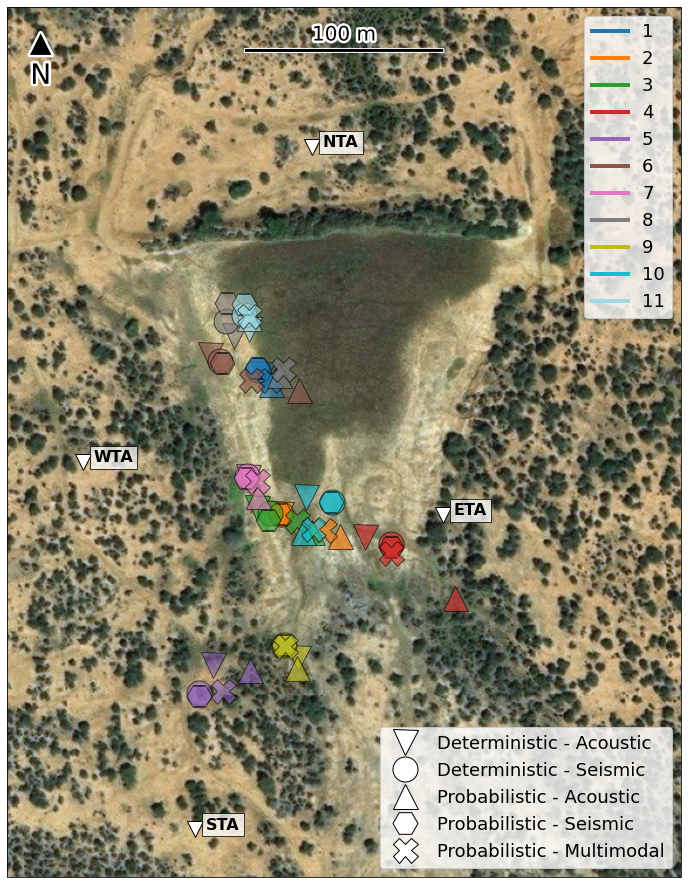

In [7]:
df = pd.read_csv('data.csv')


fig = plt.figure(figsize=(20,16)) # open matplotlib figure
ax1 = plt.axes(projection=osm_img.crs) # project using coordinate reference system (CRS) of street map

extent = [center_pt[1]-(zoom)*0.75,center_pt[1]+(zoom)*0.8,center_pt[0]-zoom,center_pt[0]+zoom] # adjust to zoom
ax1.set_extent(extent) # set extents

scale = np.ceil(-np.sqrt(2)*np.log(np.divide(zoom,350.0))) # empirical solve for scale based on zoom
scale = (scale<20) and scale or 19 # scale cannot be larger than 19
ax1.add_image(osm_img, int(scale)) # add OSM with zoom specification
ax1.set_xticks([]) # set longitude indicators
ax1.set_yticks([]) # set latitude indicators
map_tools.scale_bar(ax1, ccrs.PlateCarree(), 100, m_per_unit=1, units='m')

ax1.plot(coordinates['STA02'][0], coordinates['STA02'][1], markersize=16,marker='v',linestyle='',color='white',transform=ccrs.PlateCarree(), markeredgecolor='black')
ax1.plot(coordinates['ETA00'][0], coordinates['ETA00'][1], markersize=16,marker='v',linestyle='',color='white',transform=ccrs.PlateCarree(), markeredgecolor='black')
ax1.plot(coordinates['WTA00'][0], coordinates['WTA00'][1], markersize=16,marker='v',linestyle='',color='white',transform=ccrs.PlateCarree(), markeredgecolor='black')
ax1.plot(coordinates['NTA02'][0], coordinates['NTA02'][1], markersize=16,marker='v',linestyle='',color='white',transform=ccrs.PlateCarree(), markeredgecolor='black')

ax1.text(coordinates['STA02'][0]+0.00005,coordinates['STA02'][1], 'STA', bbox=dict(facecolor='white', alpha=0.75), horizontalalignment='left', fontsize=16, weight='bold', transform=ccrs.Geodetic())
ax1.text(coordinates['ETA00'][0]+0.00005, coordinates['ETA00'][1], 'ETA', bbox=dict(facecolor='white', alpha=0.75), horizontalalignment='left', fontsize=16, weight='bold', transform=ccrs.Geodetic())
ax1.text(coordinates['WTA00'][0]+0.00005,coordinates['WTA00'][1], 'WTA', bbox=dict(facecolor='white', alpha=0.75), horizontalalignment='left', fontsize=16, weight='bold', transform=ccrs.Geodetic())
ax1.text(coordinates['NTA02'][0]+0.00005,coordinates['NTA02'][1], 'NTA', bbox=dict(facecolor='white', alpha=0.75), horizontalalignment='left', fontsize=16, weight='bold', transform=ccrs.Geodetic())

color=iter(plt.cm.tab20(np.linspace(0,1,11)))

colors = []

for index,event in df.iterrows():
    print(event['event_num'])   

    c=next(color)
    
    x = event['x_best_acoustic_det']
    y = event['y_best_acoustic_det']
    x = x - x_correction_map
    y = y - y_correction_map 
    x,y = p(x,y,inverse=True)
    ax1.plot(x,y, markersize=25,marker='v',linestyle='',color=c,transform=ccrs.PlateCarree(), markeredgecolor='black', alpha=0.6)

    x = event['x_best_seismic_det']
    y = event['y_best_seismic_det']
    x = x - x_correction_map
    y = y - y_correction_map 
    x,y = p(x,y,inverse=True)
    ax1.plot(x,y, markersize=25,marker='o',linestyle='',color=c,transform=ccrs.PlateCarree(), markeredgecolor='black', alpha=0.6)

    x = event['x_best_acoustic_prob']
    y = event['y_best_acoustic_prob']
    x = x - x_correction_map
    y = y - y_correction_map 
    x,y = p(x,y,inverse=True)
    ax1.plot(x,y, markersize=25,marker='^',linestyle='',color=c,transform=ccrs.PlateCarree(), markeredgecolor='black', alpha=0.6)

    x = event['x_best_seismic_prob']
    y = event['y_best_seismic_prob']
    x = x - x_correction_map
    y = y - y_correction_map 
    x,y = p(x,y,inverse=True)
    ax1.plot(x,y, markersize=25,marker='H',linestyle='',color=c,transform=ccrs.PlateCarree(), markeredgecolor='black', alpha=0.6)
    
    x = event['x_best_multi_prob']
    y = event['y_best_multi_prob']
    x = x - x_correction_map
    y = y - y_correction_map 
    x,y = p(x,y,inverse=True)
    ax1.plot(x,y, markersize=25,marker='X',linestyle='',color=c,transform=ccrs.PlateCarree(), markeredgecolor='black', alpha=0.6)

    
legend1 = []
legend1_names = []

color=iter(plt.cm.tab20(np.linspace(0,1,11)))

for index,event in df.iterrows():
    c=next(color)
    legend1.append(Line2D([0], [0], color=c, lw=4))
    legend1_names.append(index+1)
    
    
print(legend1)
print(legend1_names)
    
leg1 = ax1.legend(legend1,legend1_names, fontsize=18, loc='upper right')

legend2_names = ['Deterministic - Acoustic',
                 'Deterministic - Seismic',
                 'Probabilistic - Acoustic',
                 'Probabilistic - Seismic',
                 'Probabilistic - Multimodal']

legend2 = [Line2D([], [], color='white', marker='v', markeredgecolor='black', linestyle='None', markersize=25),
           Line2D([], [], color='white', marker='o', markeredgecolor='black', linestyle='None', markersize=25),
           Line2D([], [], color='white', marker='^', markeredgecolor='black', linestyle='None', markersize=25),
           Line2D([], [], color='white', marker='H', markeredgecolor='black', linestyle='None', markersize=25),
           Line2D([], [], color='white', marker='X', markeredgecolor='black', linestyle='None', markersize=25)]
           

leg2 = ax1.legend(legend2,legend2_names, fontsize=18, loc='lower right')

ax1.add_artist(leg1)   
plt.savefig('all_locations_updated.png', bbox_inches='tight', pad_inches=0)

/home/michael/anaconda3/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:761: UserWarning: Approximating coordinate system <cartopy._crs.Geodetic object at 0x7f7905622b80> with the PlateCarree projection.
  warnings.warn('Approximating coordinate system {!r} with the '


1418
1427
1429
1448
1525
2039
4740
5493
7564
[<matplotlib.lines.Line2D object at 0x7f7904bfa160>, <matplotlib.lines.Line2D object at 0x7f79044807c0>, <matplotlib.lines.Line2D object at 0x7f7904bfa400>, <matplotlib.lines.Line2D object at 0x7f7904a461c0>, <matplotlib.lines.Line2D object at 0x7f7904a469d0>, <matplotlib.lines.Line2D object at 0x7f7904a46610>, <matplotlib.lines.Line2D object at 0x7f790450b0a0>, <matplotlib.lines.Line2D object at 0x7f78fdd63d60>, <matplotlib.lines.Line2D object at 0x7f790566a610>]
[1, 2, 3, 4, 5, 6, 7, 8, 9]


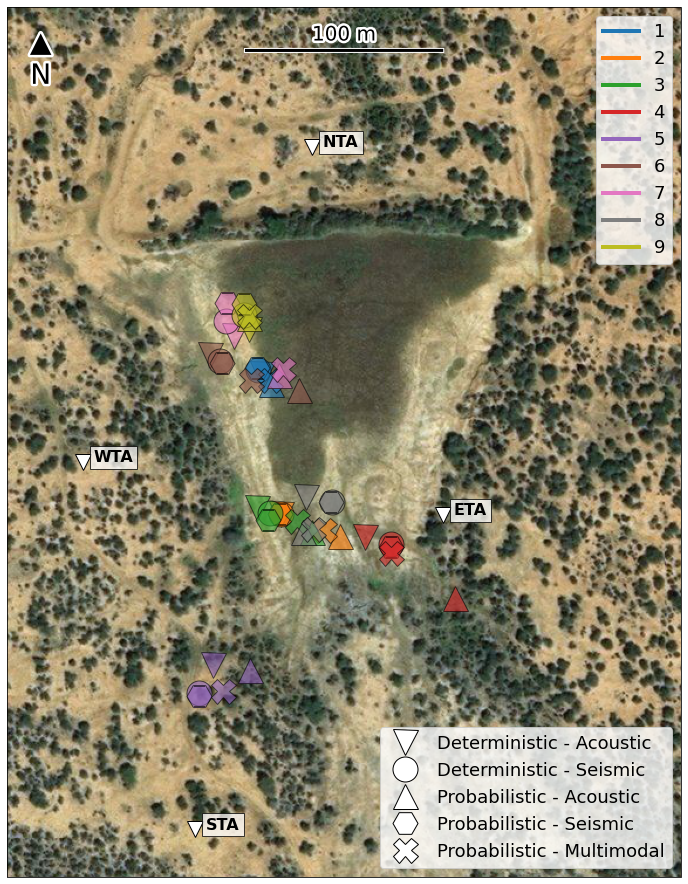

In [13]:
df = pd.read_csv('data_droppedtwo.csv')


fig = plt.figure(figsize=(20,16)) # open matplotlib figure
ax1 = plt.axes(projection=osm_img.crs) # project using coordinate reference system (CRS) of street map

extent = [center_pt[1]-(zoom)*0.75,center_pt[1]+(zoom)*0.8,center_pt[0]-zoom,center_pt[0]+zoom] # adjust to zoom
ax1.set_extent(extent) # set extents

scale = np.ceil(-np.sqrt(2)*np.log(np.divide(zoom,350.0))) # empirical solve for scale based on zoom
scale = (scale<20) and scale or 19 # scale cannot be larger than 19
ax1.add_image(osm_img, int(scale)) # add OSM with zoom specification
ax1.set_xticks([]) # set longitude indicators
ax1.set_yticks([]) # set latitude indicators
map_tools.scale_bar(ax1, ccrs.PlateCarree(), 100, m_per_unit=1, units='m')

ax1.plot(coordinates['STA02'][0], coordinates['STA02'][1], markersize=16,marker='v',linestyle='',color='white',transform=ccrs.PlateCarree(), markeredgecolor='black')
ax1.plot(coordinates['ETA00'][0], coordinates['ETA00'][1], markersize=16,marker='v',linestyle='',color='white',transform=ccrs.PlateCarree(), markeredgecolor='black')
ax1.plot(coordinates['WTA00'][0], coordinates['WTA00'][1], markersize=16,marker='v',linestyle='',color='white',transform=ccrs.PlateCarree(), markeredgecolor='black')
ax1.plot(coordinates['NTA02'][0], coordinates['NTA02'][1], markersize=16,marker='v',linestyle='',color='white',transform=ccrs.PlateCarree(), markeredgecolor='black')

ax1.text(coordinates['STA02'][0]+0.00005,coordinates['STA02'][1], 'STA', bbox=dict(facecolor='white', alpha=0.75), horizontalalignment='left', fontsize=16, weight='bold', transform=ccrs.Geodetic())
ax1.text(coordinates['ETA00'][0]+0.00005, coordinates['ETA00'][1], 'ETA', bbox=dict(facecolor='white', alpha=0.75), horizontalalignment='left', fontsize=16, weight='bold', transform=ccrs.Geodetic())
ax1.text(coordinates['WTA00'][0]+0.00005,coordinates['WTA00'][1], 'WTA', bbox=dict(facecolor='white', alpha=0.75), horizontalalignment='left', fontsize=16, weight='bold', transform=ccrs.Geodetic())
ax1.text(coordinates['NTA02'][0]+0.00005,coordinates['NTA02'][1], 'NTA', bbox=dict(facecolor='white', alpha=0.75), horizontalalignment='left', fontsize=16, weight='bold', transform=ccrs.Geodetic())

color=iter(plt.cm.tab20(np.linspace(0,1,11)))

colors = []

for index,event in df.iterrows():
    print(event['event_num'])   

    c=next(color)
    
    x = event['x_best_acoustic_det']
    y = event['y_best_acoustic_det']
    x = x - x_correction_map
    y = y - y_correction_map 
    x,y = p(x,y,inverse=True)
    ax1.plot(x,y, markersize=25,marker='v',linestyle='',color=c,transform=ccrs.PlateCarree(), markeredgecolor='black', alpha=0.6)

    x = event['x_best_seismic_det']
    y = event['y_best_seismic_det']
    x = x - x_correction_map
    y = y - y_correction_map 
    x,y = p(x,y,inverse=True)
    ax1.plot(x,y, markersize=25,marker='o',linestyle='',color=c,transform=ccrs.PlateCarree(), markeredgecolor='black', alpha=0.6)

    x = event['x_best_acoustic_prob']
    y = event['y_best_acoustic_prob']
    x = x - x_correction_map
    y = y - y_correction_map 
    x,y = p(x,y,inverse=True)
    ax1.plot(x,y, markersize=25,marker='^',linestyle='',color=c,transform=ccrs.PlateCarree(), markeredgecolor='black', alpha=0.6)

    x = event['x_best_seismic_prob']
    y = event['y_best_seismic_prob']
    x = x - x_correction_map
    y = y - y_correction_map 
    x,y = p(x,y,inverse=True)
    ax1.plot(x,y, markersize=25,marker='H',linestyle='',color=c,transform=ccrs.PlateCarree(), markeredgecolor='black', alpha=0.6)
    
    x = event['x_best_multi_prob']
    y = event['y_best_multi_prob']
    x = x - x_correction_map
    y = y - y_correction_map 
    x,y = p(x,y,inverse=True)
    ax1.plot(x,y, markersize=25,marker='X',linestyle='',color=c,transform=ccrs.PlateCarree(), markeredgecolor='black', alpha=0.6)

    
legend1 = []
legend1_names = []

color=iter(plt.cm.tab20(np.linspace(0,1,11)))

for index,event in df.iterrows():
    c=next(color)
    legend1.append(Line2D([0], [0], color=c, lw=4))
    legend1_names.append(index+1)
    
    
print(legend1)
print(legend1_names)
    
leg1 = ax1.legend(legend1,legend1_names, fontsize=18, loc='upper right')

legend2_names = ['Deterministic - Acoustic',
                 'Deterministic - Seismic',
                 'Probabilistic - Acoustic',
                 'Probabilistic - Seismic',
                 'Probabilistic - Multimodal']

legend2 = [Line2D([], [], color='white', marker='v', markeredgecolor='black', linestyle='None', markersize=25),
           Line2D([], [], color='white', marker='o', markeredgecolor='black', linestyle='None', markersize=25),
           Line2D([], [], color='white', marker='^', markeredgecolor='black', linestyle='None', markersize=25),
           Line2D([], [], color='white', marker='H', markeredgecolor='black', linestyle='None', markersize=25),
           Line2D([], [], color='white', marker='X', markeredgecolor='black', linestyle='None', markersize=25)]
           

leg2 = ax1.legend(legend2,legend2_names, fontsize=18, loc='lower right')

ax1.add_artist(leg1)   
#plt.savefig('all_locations_droppedtwo.png', bbox_inches='tight', pad_inches=0)
plt.savefig('all_locations_droppedtwo.svg', bbox_inches='tight', pad_inches=0)